In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import feather

PID = 'gasco-analytics'

In [2]:
query = '''WITH encuestas AS
(
(SELECT *EXCEPT(ID_Pedido) FROM `gasco-analytics.encuestas.encuestas_segmentacion`) 
UNION ALL
(SELECT 
A__o, 
Mes,
ID_PEDIDO ID_Gasconnect,
ID_SAT, 
Segmento Segmento_,
Comuna,
Estufa,
Cocina,
Calefont,
Parrilla,
Edad,
Sexo,
GSE,
Telefono_Contacto
FROM encuestas.202102_encuestas_uso))


SELECT *EXCEPT(estufa,cocina,calefont,parrilla),
CASE
WHEN estufa = 1 AND cocina = 0 AND calefont = 0 AND parrilla = 0 THEN 0
WHEN estufa = 0 AND cocina = 1 AND calefont = 0 AND parrilla = 0 THEN 0
WHEN estufa = 0 AND cocina = 0 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 0 AND cocina = 0 AND calefont = 0 AND parrilla = 1 THEN 0
WHEN estufa = 1 AND cocina = 1 AND calefont = 1 AND parrilla = 1 THEN 1
WHEN estufa = 1 AND cocina = 1 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 0 AND cocina = 0 AND calefont = 1 AND parrilla = 1 THEN 1
WHEN estufa = 0 AND cocina = 1 AND calefont = 0 AND parrilla = 1 THEN 0
WHEN estufa = 1 AND cocina = 0 AND calefont = 0 AND parrilla = 1 THEN 0
WHEN estufa = 0 AND cocina = 1 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 1 AND cocina = 0 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 1 AND cocina = 1 AND calefont = 0 AND parrilla = 0 THEN 0
ELSE 0
END uso_gas
FROM
(SELECT * FROM (
WITH con_bookingId AS
(SELECT ids.*, pedidos.*
FROM
(SELECT ID_Gasconnect  encuestados, Segmento_,
SUM(IF(estufa is not null, 1, 0)) estufa,
SUM(IF(cocina is not null, 1, 0)) cocina,
SUM(IF(calefont is not null, 1, 0)) calefont,
SUM(IF(parrilla is not null, 1, 0)) parrilla,
max(edad) edad,
max(sexo) sexo
FROM encuestas
GROUP BY ID_Gasconnect, Segmento_) ids
LEFT JOIN `gasco.Pedidos_Gasconnect_Bruta`  pedidos
ON CAST(ids.encuestados AS FLOAT64) = pedidos.bookingId
WHERE bookingId is not null)
,
con_satId AS
(SELECT ids.*, pedidos.*
FROM
(SELECT ID_SAT encuestados, Segmento_,
SUM(IF(estufa is not null, 1, 0)) estufa,
SUM(IF(cocina is not null, 1, 0)) cocina,
SUM(IF(calefont is not null, 1, 0)) calefont,
SUM(IF(parrilla is not null, 1, 0)) parrilla,
max(edad) edad,
max(sexo) sexo
FROM encuestas
GROUP BY ID_SAT, Segmento_) ids
LEFT JOIN `gasco.Pedidos_Gasconnect_Bruta`  pedidos
ON CAST(ids.encuestados AS FLOAT64) = CAST(pedidos.satId AS FLOAT64)
WHERE satId  is not null)
,
clientes AS
(SELECT 
CASE 
WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
ELSE null
END AS telefono, edad, sexo, estufa, cocina, calefont, parrilla
--date_diff(extract(date from createdat),LAG(extract(date from createdat)) OVER(partition by mobile, customerNoIfOffline ORDER BY extract(date from createdat)), DAY) frec_compra
FROM
(SELECT *
FROM con_bookingId
UNION ALL
(SELECT *
FROM con_satId))
)

SELECT telefono,
max(mobile) mobile,
max(customerNoIfOffline) customerNoIfOffline,
--EDAD
--GSE
--dia de la semana (por día)
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 1,1,0)) compras_domingo,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 2,1,0)) compras_lunes,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 3,1,0)) compras_martes,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 4,1,0)) compras_miercoles,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 5,1,0)) compras_jueves,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 6,1,0)) compras_viernes,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 7,1,0)) compras_sabado,
--mes de compra (por estación)
SUM(IF(EXTRACT(MONTH FROM createdat) IN (12,1,2),1,0)) compras_verano,
SUM(IF(EXTRACT(MONTH FROM createdat) IN (3,4,5),1,0)) compras_otonio,
SUM(IF(EXTRACT(MONTH FROM createdat) IN (6,7,8),1,0)) compras_invierno,
SUM(IF(EXTRACT(MONTH FROM createdat) IN (9,10,11),1,0)) compras_primavera,
--frecuencia (hacer con lag)
--ROUND(avg(frec_compra),2) frec_compra,
TRIM(STRING_AGG(DISTINCT(IF(orden_pedidos_clientes=1,sector,'')),'')) comuna, 
COUNT(DISTINCT(address)) distintas_direcciones,
--IF(SUM(IF(depto IS NOT NULL,1,0))>0,'depto','casa') depto_casa, -- si tiene varias direcciones y una es depto, va a ser un cliente "depto"
IF(SUM(IF(address LIKE '%depto%' OR address LIKE '%dpto%' OR address LIKE '%departamento%' OR address LIKE '%dto%' OR address LIKE '%dp%' OR address LIKE '%dppt%' OR address LIKE '%dpt%' OR address LIKE '%edificio%' , 1, 0 ))>0,1,0)  depto_casa,
CASE
WHEN max(edad)<=24 THEN 1
WHEN max(edad)>24 AND max(edad)<=34 THEN 2
WHEN max(edad)>34 AND max(edad)<=44 THEN 3
WHEN max(edad)>44 AND max(edad)<=54 THEN 4
WHEN max(edad)>54 AND max(edad)<=64 THEN 5
WHEN max(edad)>64 THEN 6
ELSE null
END edad,
max(sexo) sexo,
COUNT(*) cantidad_pedidos,
SUM(totalAmount_GC) suma_pedido, 
SUM(discountAmount) suma_descuentos, --hay que sumar los cupones? cambiar esta variable? Tomar alguna variable de cupones o campañas?.. Hacer CASE con online/offline
SUM(total_kilos_pedido) suma_kilos,
SUM(p_CN02) suma_p_CN02,
SUM(p_CN05)+SUM(p_CS05) suma_formato_05, 
SUM(p_CN11)+SUM(p_CS11) suma_formato_11, 
SUM(p_CN15)+SUM(p_CS15) suma_formato_15, 
SUM(p_CN45)+SUM(p_CS45) suma_formato_45, 
SUM(p_CGH15) suma_p_CGH15, 
SUM(p_CGH15_AL) suma_p_CGH15_AL, 
SUM(p_GGH15_AL) suma_p_GGH15_AL,
ROUND(AVG(frecuencia),1) frec_compra_promedio_dias,
IF(SUM(IF(tipo_pedido_bien = 'OFFLINE',1,0))>0,1,0) canal_offline,
IF(SUM(IF(tipo_pedido_bien = 'ONLINE',1,0))>0,1,0) canal_online,
IF(SUM(IF(tipo_pedido_bien NOT IN ('ONLINE','OFFLINE'),1,0))>0,1,0) otro_canal,
IF(SUM(IF(paymentMethodDescription = 'Efectivo',1,0))>0,1,0) pago_efectivo,
IF(SUM(IF(paymentMethodDescription = 'Tarjeta Debito/Credito',1,0))>0,1,0) pago_deb_cred,
IF(SUM(IF(paymentMethodDescription = 'CuentaRUT/Ctas BancoEstado',1,0))>0,1,0) pago_bco_estado,
IF(SUM(IF(paymentMethodDescription NOT IN ('CuentaRUT/Ctas BancoEstado','Tarjeta Debito/Credito','Efectivo'),1,0))>0,1,0) pago_otros,
IF(SUM(estufa)>0,1,0) estufa,
IF(SUM(cocina)>0,1,0) cocina,
IF(SUM(calefont)>0,1,0) calefont,
IF(SUM(parrilla)>0,1,0) parrilla
FROM 
(SELECT clientes.*EXCEPT(telefono), pedidos_javier.*,
DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) frecuencia,
row_number() OVER(PARTITION BY telefono ORDER BY createdat DESC) orden_pedidos_clientes,
FROM
(SELECT * FROM clientes) clientes
LEFT JOIN (select *,
CASE 
WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
ELSE null
END AS telefono FROM `gasco.pedidos_gasconnect_todos_javier`) pedidos_javier
USING(telefono)) 
GROUP BY telefono
)
WHERE mobile NOT IN ('949700781','987446282','946272711','959855281','937198925','982834413','940320641','933486794','968495840','982169639','976719792','976837510','946900115','952311351','966376800','938728120','920165243','937181726','936105770','999755969','956037246','971393407','964272568','996937599','958284792','944210340','972379273','931776921','981218376','930550981','938762481','949152671','989143697','969034005','986498191','920767324','944088616','975301909','920031082','994060817','965892521','953211031','956111329','995696387','966447842','996461327','997936889','933569506','933763374','936831280','985518824','973616165','959886604','965845250','973905440','956945238','965847403','954433370','957660478','948104628','966148636','967120855','947844436','969027661','959624405','977497046','950208898','957999693','989708139','986711311','982651844','952101141','962320325','933396681','948703345','972840071','981959179','975933937','945779141','945779142','937411889','978556265','951886537','932592671','964435798','987149470','920596293','987110816','979505347','935543084','996129257','954838361','959938922','950888056','936831280','954653898','965838210','965688521','959865600','956654007','942281547','965296076','972045344','968281852','942399781','992708206','952564809','976299318','997862235','950725383','930731503','944906499','931830297','935544746','966294876','989255095','994842012','966996365','978994717','978805734','965265205','942556019','935544746','967514899','950208898','968429653','940312619','987492429','963868077','994497785','965937013','948116910','986757302','945168176','973772861','954423660','987070184','950207273','968495840','976100365','991675804','973345579','946274646','995994648','982808794','931238125','985326354','930910440','981990488','955304961','966863150','978257363','935224124','984114608','952240390','932957108','938866484','947906680','990573502','950384188','962787325','995476328','932598533','935544746','920300776','977067735','941186610','945765224','997250292','941606975','950738096','920610205','998853511','993245736','920315263','964814674','982507874','956678416','920282559','978225968','945797466','995766773','987268438','991409989','968665725','920394138','935157070','978187654','964451113','930319282','940521015','936547434','971023190','966974624','936892997','989203774','935544746','957942982','987212671','963518304','954433370','940017083','973551964','961988683','977663841','972585152','946589725','964779674','984419260','997626843','941040263','937068078','972398188','940884370','944685598','937056940','949360373','988991779','949275692','946158245','968034996','961412983','986701122','958475876','998250053') 
OR customerNoifOffline NOT IN ('949700781','987446282','946272711','959855281','937198925','982834413','940320641','933486794','968495840','982169639','976719792','976837510','946900115','952311351','966376800','938728120','920165243','937181726','936105770','999755969','956037246','971393407','964272568','996937599','958284792','944210340','972379273','931776921','981218376','930550981','938762481','949152671','989143697','969034005','986498191','920767324','944088616','975301909','920031082','994060817','965892521','953211031','956111329','995696387','966447842','996461327','997936889','933569506','933763374','936831280','985518824','973616165','959886604','965845250','973905440','956945238','965847403','954433370','957660478','948104628','966148636','967120855','947844436','969027661','959624405','977497046','950208898','957999693','989708139','986711311','982651844','952101141','962320325','933396681','948703345','972840071','981959179','975933937','945779141','945779142','937411889','978556265','951886537','932592671','964435798','987149470','920596293','987110816','979505347','935543084','996129257','954838361','959938922','950888056','936831280','954653898','965838210','965688521','959865600','956654007','942281547','965296076','972045344','968281852','942399781','992708206','952564809','976299318','997862235','950725383','930731503','944906499','931830297','935544746','966294876','989255095','994842012','966996365','978994717','978805734','965265205','942556019','935544746','967514899','950208898','968429653','940312619','987492429','963868077','994497785','965937013','948116910','986757302','945168176','973772861','954423660','987070184','950207273','968495840','976100365','991675804','973345579','946274646','995994648','982808794','931238125','985326354','930910440','981990488','955304961','966863150','978257363','935224124','984114608','952240390','932957108','938866484','947906680','990573502','950384188','962787325','995476328','932598533','935544746','920300776','977067735','941186610','945765224','997250292','941606975','950738096','920610205','998853511','993245736','920315263','964814674','982507874','956678416','920282559','978225968','945797466','995766773','987268438','991409989','968665725','920394138','935157070','978187654','964451113','930319282','940521015','936547434','971023190','966974624','936892997','989203774','935544746','957942982','987212671','963518304','954433370','940017083','973551964','961988683','977663841','972585152','946589725','964779674','984419260','997626843','941040263','937068078','972398188','940884370','944685598','937056940','949360373','988991779','949275692','946158245','968034996','961412983','986701122','958475876','998250053')
)'''

df = pd.read_gbq(query=query, project_id=PID, dialect="standard", use_bqstorage_api=True) 

In [3]:
df.head()

,telefono,mobile,customerNoIfOffline,compras_domingo,compras_lunes,compras_martes,compras_miercoles,compras_jueves,compras_viernes,compras_sabado,...,suma_p_GGH15_AL,frec_compra_promedio_dias,canal_offline,canal_online,otro_canal,pago_efectivo,pago_deb_cred,pago_bco_estado,pago_otros,uso_gas
0,12536246,0000000000,12536246,0,1,0,0,0,0,0,...,0,NaN,1,0,0,1,0,0,0,0
1,222923965,0000000000,222923965,0,2,4,1,6,2,0,...,0,84.1,1,0,0,1,1,0,0,0
2,223111432,223111432,223111432,0,0,0,3,1,2,1,...,0,81.8,1,0,0,1,1,0,0,1
3,322948095,0000000000,322948095,2,0,0,1,3,0,1,...,0,25.0,1,0,0,1,0,0,0,1
4,552378337,0000000000,552378337,0,1,2,2,4,1,5,...,0,76.9,1,0,0,1,0,0,0,0


In [4]:
numeric = ['compras_domingo',
 'compras_lunes',
 'compras_martes',
 'compras_miercoles',
 'compras_jueves',
 'compras_viernes',
 'compras_sabado',
 'compras_verano',
 'compras_otonio',
 'compras_invierno',
 'compras_primavera',
 'cantidad_pedidos',
 'edad',
 'suma_pedido',
 'suma_descuentos',
 'suma_kilos',
 'suma_p_CN02',
 'suma_formato_05',
 'suma_formato_11',
 'suma_formato_15',
 'suma_formato_45',
 'suma_p_CGH15',
 'suma_p_CGH15_AL',
 'suma_p_GGH15_AL',
 'frec_compra_promedio_dias']

categorical = ['comuna',
 'depto_casa',
 'sexo',
 'canal_offline',
 'canal_online',
 'otro_canal',
 'pago_efectivo',
 'pago_deb_cred',
 'pago_bco_estado',
 'pago_otros']

#No considerar
otras = ['telefono',
 'mobile',
 'customerNoIfOffline',
 'distintas_direcciones']

In [5]:
import h2o
from h2o.automl import H2OAutoML

In [6]:
features = numeric + categorical
H2O_server = h2o.init(port=54321, min_mem_size='15g')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /home/ubuntu/miniconda3/envs/spike_basicoV5/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppo4aspxu
  JVM stdout: /tmp/tmppo4aspxu/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmppo4aspxu/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,"1 year, 3 months and 18 days !!!"
H2O cluster name:,H2O_from_python_ubuntu_6cbzl7
H2O cluster total nodes:,1
H2O cluster free memory:,15 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [7]:
target = 'uso_gas'
features = numeric + categorical
H2O_server = h2o.init(port=54321, min_mem_size='15g')
h2o.remove_all()

df_h2o = h2o.H2OFrame(df)
df_h2o['uso_gas'] = df_h2o['uso_gas'].asfactor()

#Explícitamente transformar a categóricas
for feature in categorical:
    df_h2o[feature] = df_h2o[feature].asfactor()

train, test = df_h2o.split_frame(ratios=[0.8], seed=7161)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,"1 year, 3 months and 18 days !!!"
H2O cluster name:,H2O_from_python_ubuntu_6cbzl7
H2O cluster total nodes:,1
H2O cluster free memory:,15 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
horas = 1.5
aml = H2OAutoML(max_runtime_secs = int(60*60*horas), seed=1010102,
                project_name="modelo_gasco_calefont")

aml.train(x=features, y=target,
          training_frame=train,
         validation_frame = test)

lb = aml.leaderboard
lb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210217_145227,0.71825,0.576883,0.399153,0.443581,0.196764
StackedEnsemble_BestOfFamily_AutoML_20210217_145227,0.715022,0.579625,0.408603,0.444656,0.197719
GBM_grid_1_AutoML_20210217_145227_model_23,0.713259,0.605808,0.405899,0.456284,0.208195
GBM_grid_1_AutoML_20210217_145227_model_10,0.711216,0.616564,0.414592,0.461648,0.213119
XGBoost_3_AutoML_20210217_145227,0.711113,0.582631,0.415146,0.446131,0.199033
XGBoost_1_AutoML_20210217_145227,0.711034,0.582792,0.411584,0.446181,0.199078
GBM_grid_1_AutoML_20210217_145227_model_2,0.710788,0.597228,0.411563,0.452116,0.204409
GBM_grid_1_AutoML_20210217_145227_model_28,0.710503,0.631085,0.400833,0.469014,0.219974
XGBoost_grid_1_AutoML_20210217_145227_model_5,0.710503,0.582962,0.413173,0.446159,0.199057
XGBoost_grid_1_AutoML_20210217_145227_model_1,0.710404,0.582656,0.412304,0.446115,0.199019


In [9]:
data_path = '/home/ubuntu/spike/Emi/modelo_uso_gas/202102/'

In [ ]:
XGBoost_grid_1_AutoML_20200909_163641_model_6

In [11]:
stack_winner = h2o.get_model("GBM_grid_1_AutoML_20210217_145227_model_23")
h2o.save_model(model=stack_winner, force=True)

'/home/ubuntu/GBM_grid_1_AutoML_20210217_145227_model_23'

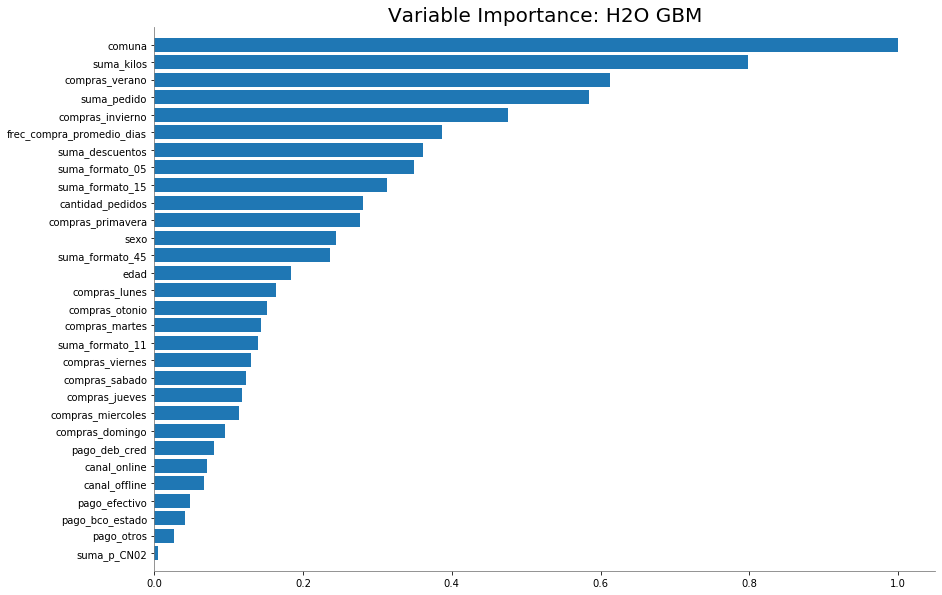

In [12]:
stack_winner.varimp_plot(30)

In [13]:
nombre_modelo = 'GBM_grid_1_AutoML_20210217_145227_model_23'

In [19]:
query_test = """

SELECT *EXCEPT(estufa,cocina,calefont,parrilla),
CASE
WHEN estufa = 1 AND cocina = 0 AND calefont = 0 AND parrilla = 0 THEN 0
WHEN estufa = 0 AND cocina = 1 AND calefont = 0 AND parrilla = 0 THEN 0
WHEN estufa = 0 AND cocina = 0 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 0 AND cocina = 0 AND calefont = 0 AND parrilla = 1 THEN 0
WHEN estufa = 1 AND cocina = 1 AND calefont = 1 AND parrilla = 1 THEN 1
WHEN estufa = 1 AND cocina = 1 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 0 AND cocina = 0 AND calefont = 1 AND parrilla = 1 THEN 1
WHEN estufa = 0 AND cocina = 1 AND calefont = 0 AND parrilla = 1 THEN 0
WHEN estufa = 1 AND cocina = 0 AND calefont = 0 AND parrilla = 1 THEN 0
WHEN estufa = 0 AND cocina = 1 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 1 AND cocina = 0 AND calefont = 1 AND parrilla = 0 THEN 1
WHEN estufa = 1 AND cocina = 1 AND calefont = 0 AND parrilla = 0 THEN 0
ELSE 0
END uso_gas
FROM
(SELECT * FROM (
WITH 
Encuestas AS (
SELECT ids.*, pedidos.* FROM (
SELECT EMAIL,
SUM(IF(estufa =1, 1, 0)) estufa,
SUM(IF(cocina =1, 1, 0)) cocina,
SUM(IF(calefont =1, 1, 0)) calefont,
SUM(IF(parrilla =1, 1, 0)) parrilla,
max(edad) edad,
FROM `encuestas.Encuestas_USO_Agosto` 
GROUP BY EMAIL) ids
LEFT JOIN `gasco.Pedidos_Gasconnect_Bruta`  pedidos
ON ids.EMAIL = pedidos.email
WHERE ids.email is not null)
/*con_bookingId AS
(SELECT ids.*, pedidos.*
FROM
(SELECT ID_Gasconnect  encuestados, Segmento_,
SUM(IF(estufa is not null, 1, 0)) estufa,
SUM(IF(cocina is not null, 1, 0)) cocina,
SUM(IF(calefont is not null, 1, 0)) calefont,
SUM(IF(parrilla is not null, 1, 0)) parrilla,
max(edad) edad,
max(sexo) sexo
FROM `encuestas.encuestas_segmentacion`
GROUP BY ID_Gasconnect, Segmento_) ids
LEFT JOIN `gasco.Pedidos_Gasconnect_Bruta`  pedidos
ON CAST(ids.encuestados AS FLOAT64) = pedidos.bookingId
WHERE bookingId is not null)
,
con_satId AS
(SELECT ids.*, pedidos.*
FROM
(SELECT ID_SAT encuestados, Segmento_,
SUM(IF(estufa =1, 1, 0)) estufa,
SUM(IF(cocina =1, 1, 0)) cocina,
SUM(IF(calefont =1, 1, 0)) calefont,
SUM(IF(parrilla =1, 1, 0)) parrilla,
max(edad) edad,
max(sexo) sexo
FROM `encuestas.encuestas_segmentacion`
GROUP BY ID_SAT, Segmento_) ids
LEFT JOIN `gasco.Pedidos_Gasconnect_Bruta`  pedidos
ON CAST(ids.encuestados AS FLOAT64) = CAST(pedidos.satId AS FLOAT64)
WHERE satId  is not null)*/
,
clientes AS
(SELECT 
CASE 
WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
ELSE null
END AS telefono, edad, estufa, cocina, calefont, parrilla
--date_diff(extract(date from createdat),LAG(extract(date from createdat)) OVER(partition by mobile, customerNoIfOffline ORDER BY extract(date from createdat)), DAY) frec_compra
FROM
(SELECT * FROM Encuestas
/*SELECT *
FROM con_bookingId
UNION ALL
(SELECT *
FROM con_satId)*/)
)
SELECT telefono,
max(mobile) mobile,
max(customerNoIfOffline) customerNoIfOffline,
--EDAD
--GSE
--dia de la semana (por día)
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 1,1,0)) compras_domingo,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 2,1,0)) compras_lunes,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 3,1,0)) compras_martes,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 4,1,0)) compras_miercoles,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 5,1,0)) compras_jueves,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 6,1,0)) compras_viernes,
SUM(IF(EXTRACT(DAYOFWEEK FROM createdat) = 7,1,0)) compras_sabado,
--mes de compra (por estación)
SUM(IF(EXTRACT(MONTH FROM createdat) IN (12,1,2),1,0)) compras_verano,
SUM(IF(EXTRACT(MONTH FROM createdat) IN (3,4,5),1,0)) compras_otonio,
SUM(IF(EXTRACT(MONTH FROM createdat) IN (6,7,8),1,0)) compras_invierno,
SUM(IF(EXTRACT(MONTH FROM createdat) IN (9,10,11),1,0)) compras_primavera,
--frecuencia (hacer con lag)
--ROUND(avg(frec_compra),2) frec_compra,
TRIM(STRING_AGG(DISTINCT(IF(orden_pedidos_clientes=1,sector,'')),'')) comuna, 
COUNT(DISTINCT(address)) distintas_direcciones,
--IF(SUM(IF(depto IS NOT NULL,1,0))>0,'depto','casa') depto_casa, -- si tiene varias direcciones y una es depto, va a ser un cliente "depto"
IF(SUM(IF(address LIKE '%depto%' OR address LIKE '%dpto%' OR address LIKE '%departamento%' OR address LIKE '%dto%' OR address LIKE '%dp%' OR address LIKE '%dppt%' OR address LIKE '%dpt%' OR address LIKE '%edificio%' , 1, 0 ))>0,1,0)  depto_casa,
/*
(address LIKE '%depto%' 
OR address LIKE '%dpto%' 
OR address LIKE '%departamento%' 
--OR address LIKE '%dto%'
--OR address LIKE '%dp%'
--OR address LIKE '%dppt%'
--OR address LIKE '%dpt%'
--OR address LIKE '%piso%'
--OR address LIKE '%edificio%'
)*/
CASE
WHEN max(edad)<=24 THEN 1
WHEN max(edad)>24 AND max(edad)<=34 THEN 2
WHEN max(edad)>34 AND max(edad)<=44 THEN 3
WHEN max(edad)>44 AND max(edad)<=54 THEN 4
WHEN max(edad)>54 AND max(edad)<=64 THEN 5
WHEN max(edad)>64 THEN 6
ELSE null
END edad,
max(genero) sexo,
COUNT(*) cantidad_pedidos,
SUM(totalAmount_GC) suma_pedido, 
SUM(discountAmount) suma_descuentos, --hay que sumar los cupones? cambiar esta variable? Tomar alguna variable de cupones o campañas?.. Hacer CASE con online/offline
SUM(total_kilos_pedido) suma_kilos,
SUM(p_CN02) suma_p_CN02,
SUM(p_CN05)+SUM(p_CS05) suma_formato_05, 
SUM(p_CN11)+SUM(p_CS11) suma_formato_11, 
SUM(p_CN15)+SUM(p_CS15) suma_formato_15, 
SUM(p_CN45)+SUM(p_CS45) suma_formato_45, 
SUM(p_CGH15) suma_p_CGH15, 
SUM(p_CGH15_AL) suma_p_CGH15_AL, 
SUM(p_GGH15_AL) suma_p_GGH15_AL,
ROUND(AVG(frecuencia),1) frec_compra_promedio_dias,
IF(SUM(IF(tipo_pedido_bien = 'OFFLINE',1,0))>0,1,0) canal_offline,
IF(SUM(IF(tipo_pedido_bien = 'ONLINE',1,0))>0,1,0) canal_online,
IF(SUM(IF(tipo_pedido_bien NOT IN ('ONLINE','OFFLINE'),1,0))>0,1,0) otro_canal,
IF(SUM(IF(paymentMethodDescription = 'Efectivo',1,0))>0,1,0) pago_efectivo,
IF(SUM(IF(paymentMethodDescription = 'Tarjeta Debito/Credito',1,0))>0,1,0) pago_deb_cred,
IF(SUM(IF(paymentMethodDescription = 'CuentaRUT/Ctas BancoEstado',1,0))>0,1,0) pago_bco_estado,
IF(SUM(IF(paymentMethodDescription NOT IN ('CuentaRUT/Ctas BancoEstado','Tarjeta Debito/Credito','Efectivo'),1,0))>0,1,0) pago_otros,
IF(SUM(estufa)>0,1,0) estufa,
IF(SUM(cocina)>0,1,0) cocina,
IF(SUM(calefont)>0,1,0) calefont,
IF(SUM(parrilla)>0,1,0) parrilla
FROM 
(SELECT clientes.*EXCEPT(telefono), pedidos_javier.*,
DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) frecuencia,
row_number() OVER(PARTITION BY telefono ORDER BY createdat DESC) orden_pedidos_clientes,
FROM
(SELECT * FROM clientes) clientes
LEFT JOIN (select *,
CASE 
WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
ELSE null
END AS telefono FROM `gasco.pedidos_gasconnect_todos_javier`) pedidos_javier
USING(telefono)) 
GROUP BY telefono
)
WHERE mobile NOT IN ('949700781','987446282','946272711','959855281','937198925','982834413','940320641','933486794','968495840','982169639','976719792','976837510','946900115','952311351','966376800','938728120','920165243','937181726','936105770','999755969','956037246','971393407','964272568','996937599','958284792','944210340','972379273','931776921','981218376','930550981','938762481','949152671','989143697','969034005','986498191','920767324','944088616','975301909','920031082','994060817','965892521','953211031','956111329','995696387','966447842','996461327','997936889','933569506','933763374','936831280','985518824','973616165','959886604','965845250','973905440','956945238','965847403','954433370','957660478','948104628','966148636','967120855','947844436','969027661','959624405','977497046','950208898','957999693','989708139','986711311','982651844','952101141','962320325','933396681','948703345','972840071','981959179','975933937','945779141','945779142','937411889','978556265','951886537','932592671','964435798','987149470','920596293','987110816','979505347','935543084','996129257','954838361','959938922','950888056','936831280','954653898','965838210','965688521','959865600','956654007','942281547','965296076','972045344','968281852','942399781','992708206','952564809','976299318','997862235','950725383','930731503','944906499','931830297','935544746','966294876','989255095','994842012','966996365','978994717','978805734','965265205','942556019','935544746','967514899','950208898','968429653','940312619','987492429','963868077','994497785','965937013','948116910','986757302','945168176','973772861','954423660','987070184','950207273','968495840','976100365','991675804','973345579','946274646','995994648','982808794','931238125','985326354','930910440','981990488','955304961','966863150','978257363','935224124','984114608','952240390','932957108','938866484','947906680','990573502','950384188','962787325','995476328','932598533','935544746','920300776','977067735','941186610','945765224','997250292','941606975','950738096','920610205','998853511','993245736','920315263','964814674','982507874','956678416','920282559','978225968','945797466','995766773','987268438','991409989','968665725','920394138','935157070','978187654','964451113','930319282','940521015','936547434','971023190','966974624','936892997','989203774','935544746','957942982','987212671','963518304','954433370','940017083','973551964','961988683','977663841','972585152','946589725','964779674','984419260','997626843','941040263','937068078','972398188','940884370','944685598','937056940','949360373','988991779','949275692','946158245','968034996','961412983','986701122','958475876','998250053') 
OR customerNoifOffline NOT IN ('949700781','987446282','946272711','959855281','937198925','982834413','940320641','933486794','968495840','982169639','976719792','976837510','946900115','952311351','966376800','938728120','920165243','937181726','936105770','999755969','956037246','971393407','964272568','996937599','958284792','944210340','972379273','931776921','981218376','930550981','938762481','949152671','989143697','969034005','986498191','920767324','944088616','975301909','920031082','994060817','965892521','953211031','956111329','995696387','966447842','996461327','997936889','933569506','933763374','936831280','985518824','973616165','959886604','965845250','973905440','956945238','965847403','954433370','957660478','948104628','966148636','967120855','947844436','969027661','959624405','977497046','950208898','957999693','989708139','986711311','982651844','952101141','962320325','933396681','948703345','972840071','981959179','975933937','945779141','945779142','937411889','978556265','951886537','932592671','964435798','987149470','920596293','987110816','979505347','935543084','996129257','954838361','959938922','950888056','936831280','954653898','965838210','965688521','959865600','956654007','942281547','965296076','972045344','968281852','942399781','992708206','952564809','976299318','997862235','950725383','930731503','944906499','931830297','935544746','966294876','989255095','994842012','966996365','978994717','978805734','965265205','942556019','935544746','967514899','950208898','968429653','940312619','987492429','963868077','994497785','965937013','948116910','986757302','945168176','973772861','954423660','987070184','950207273','968495840','976100365','991675804','973345579','946274646','995994648','982808794','931238125','985326354','930910440','981990488','955304961','966863150','978257363','935224124','984114608','952240390','932957108','938866484','947906680','990573502','950384188','962787325','995476328','932598533','935544746','920300776','977067735','941186610','945765224','997250292','941606975','950738096','920610205','998853511','993245736','920315263','964814674','982507874','956678416','920282559','978225968','945797466','995766773','987268438','991409989','968665725','920394138','935157070','978187654','964451113','930319282','940521015','936547434','971023190','966974624','936892997','989203774','935544746','957942982','987212671','963518304','954433370','940017083','973551964','961988683','977663841','972585152','946589725','964779674','984419260','997626843','941040263','937068078','972398188','940884370','944685598','937056940','949360373','988991779','949275692','946158245','968034996','961412983','986701122','958475876','998250053')
)"""

df_test = pd.read_gbq(query=query_test, project_id=PID, dialect="standard", use_bqstorage_api=True)

In [20]:
df_h2o_test = h2o.H2OFrame(df_test)

#Explícitamente transformar a categóricas
for feature in categorical:
    df_h2o_test[feature] = df_h2o_test[feature].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
#Load model, predecir y merge
modelo = h2o.load_model(nombre_modelo)
preds = modelo.predict(df_h2o_test)
preds_y_datos = pd.concat([df_h2o_test.as_data_frame(), preds.as_data_frame()], axis=1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [22]:
preds_y_datos.to_gbq("tmp.202102_prediccion_modelo_calefont", project_id=PID, if_exists="replace")

1it [00:02,  2.22s/it]
